In [3]:
import torch
import torch.nn as nn
import tqdm
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
torch.cuda.get_device_name()

'Tesla T4'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                 transforms.ToTensor()])

In [7]:
cd cats_and_dogs/

/content/drive/My Drive/Data/cats_and_dogs


In [8]:
ls

cnd_dl.pth_100.tar  cnd_tdl_100.pth.tar  test_images/   validation_set/
cnd_dl.pth.tar      cnd_tdl.pth.tar      training_set/


In [9]:
train_set = datasets.ImageFolder(root="training_set/", transform=transform)

In [10]:
val_set = datasets.ImageFolder(root="validation_set/", transform=transform)

In [11]:
test_images = datasets.ImageFolder(root="test_images/", transform=transform)

In [12]:
len(train_set), len(val_set), len(test_images)

(8000, 2000, 2)

0


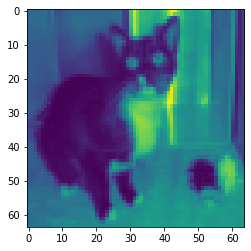

In [13]:
img, label = val_set[69]
plt.imshow(img[0, :, :])
print(label)

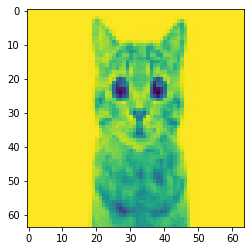

In [14]:
img, _ = test_images[0]
plt.imshow(img[0, :, :])

In [15]:
# cat - 0, dog - 1

In [22]:
train_loader = DataLoader(train_set, batch_size=100, shuffle=True) 

In [23]:
val_loader = DataLoader(val_set, batch_size=100, shuffle=True)

In [24]:
len(train_loader), len(val_loader)

(80, 20)

In [25]:
# torch.save(train_loader, "cnd_dl.pth_100.tar")

In [26]:
# torch.save(val_loader, "cnd_vdl_100.pth.tar")

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(4608, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.max_pool2d(x, 2)              
        x = F.relu(x)

        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = x.view(-1, 4608)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        return x

    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        return loss
        
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {"val_loss": loss, "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [i["val_loss"] for i in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [i["val_acc"] for i in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, results):
        print("")
        print("")
        print("Epoch: {} | val_loss: {:.4f} | val_acc: {:.4f}".format(epoch, results['val_loss'], results['val_acc']))

In [29]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
        
    return data.to(device, non_blocking=True)

In [30]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for d in self.dl: 
            yield to_device(d, self.device)

    def __len__(self):
        return len(self.dl)

In [31]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [32]:
def evaluate(model, val_loader):
    outputs = []
    print("")
    print("")
    print("Inference:")
    print("")
    for batch in tqdm.tqdm(val_loader, total=len(val_loader)):
        outputs.append(model.validation_step(batch))

    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader):
    history = []
    opt = torch.optim.Adam(model.parameters(), lr)
    for epoch in range(epochs):
        print("")
        print("Training:")
        print("")
        for batch in tqdm.tqdm(train_loader, total=len(train_loader)):
            loss = model.training_step(batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [33]:
net = Net()
to_device(net, device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [31]:
results = evaluate(net, val_dl)
results

  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



100%|██████████| 20/20 [06:41<00:00, 20.08s/it]


{'val_acc': 0.5, 'val_loss': 0.6937172412872314}

In [34]:
history = fit(epochs=15, lr=1e-3, model=net, train_loader=train_dl, val_loader=val_dl)

  0%|          | 0/80 [00:00<?, ?it/s]


Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 0 | val_loss: 0.6435 | val_acc: 0.6480

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 1 | val_loss: 0.5928 | val_acc: 0.6945

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 2 | val_loss: 0.5787 | val_acc: 0.6915

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 3 | val_loss: 0.5212 | val_acc: 0.7445

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 4 | val_loss: 0.4973 | val_acc: 0.7610

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 5 | val_loss: 0.4695 | val_acc: 0.7765

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 6 | val_loss: 0.4702 | val_acc: 0.7825

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 7 | val_loss: 0.5209 | val_acc: 0.7455

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 8 | val_loss: 0.4767 | val_acc: 0.7730

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 9 | val_loss: 0.4601 | val_acc: 0.7945

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 10 | val_loss: 0.4428 | val_acc: 0.8095

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 11 | val_loss: 0.4879 | val_acc: 0.7915

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 12 | val_loss: 0.4602 | val_acc: 0.8060

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



  0%|          | 0/80 [00:00<?, ?it/s]



Epoch: 13 | val_loss: 0.4746 | val_acc: 0.8035

Training:



  0%|          | 0/20 [00:00<?, ?it/s]



Inference:



100%|██████████| 20/20 [00:08<00:00,  2.31it/s]



Epoch: 14 | val_loss: 0.5114 | val_acc: 0.8025


In [38]:
torch.save(net.state_dict(), "pre_trained_net.pth.tar")

In [39]:
accs = []
losses = []
for h in history:
    accs.append(h["val_acc"])
    losses.append(h["val_loss"])

Text(0, 0.5, 'accuracy')

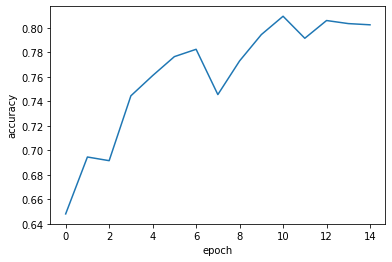

In [40]:
plt.plot(accs, "-")
plt.xlabel("epoch")
plt.ylabel("accuracy")

Text(0, 0.5, 'loss')

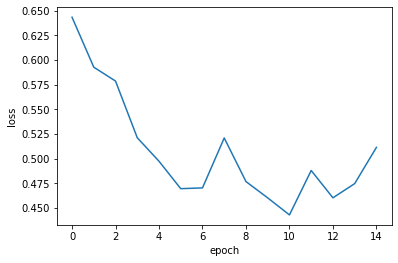

In [41]:
plt.plot(losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")

In [42]:
def predict(net, img):
    img = img.unsqueeze(0).to(device)
    output = net(img)
    _, pred = torch.max(output, dim=1)
    if pred.item() == 0:
        return "cat"
    else:
        return "dog"

In [54]:
img, _ = test_images[1]

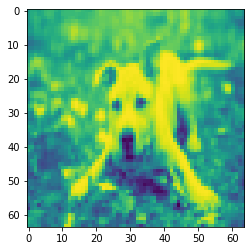

In [55]:
plt.imshow(img[0, :, :])

In [56]:
prediction = predict(net, img)

In [57]:
print(prediction)

dog
